<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/03-26-2020.csv"
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
us_pop = 329968629  #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US: {res.positive/us_pop*100:2f}%")

positive     80735
negative    438603
pending      60251
total       579589
dtype: int64
Current Infection Rate 13.929698%
Percentage of US: 0.024467%


In [7]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative
37,NY,37258,84846
34,NJ,6876,13661
5,CA,3006,17380
24,MI,2856,6550
52,WA,2580,31712
16,IL,2538,14093
21,MA,2417,21204
10,FL,2355,23741
20,LA,2305,15724
41,PA,1687,16441


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA.positive.sum().reset_index().copy()
dfCAPos = gbCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [9]:
dfUSAPos[-7:]

,date,positive,PCT
16,20200320,17038,0.211036
17,20200321,23203,0.287397
18,20200322,31888,0.394971
19,20200323,42164,0.522252
20,20200324,51970,0.643711
21,20200325,63675,0.788691
22,20200326,80735,1.000000


In [10]:
dfCAPos[-7:]

,date,positive,PCT
16,20200320,1063,0.353626
17,20200321,1279,0.425482
18,20200322,1536,0.510978
19,20200323,1733,0.576514
20,20200324,2102,0.699268
21,20200325,2102,0.699268
22,20200326,3006,1.000000


In [11]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,
20200322,31888,193463,2842,2554.0,398,228193,225351,126.0,590.0,37554.0,8685.0,46239.0
20200323,42164,237321,14571,3325.0,471,294056,279485,73.0,771.0,43858.0,10276.0,54134.0
20200324,51970,292758,14433,4468.0,675,359161,344728,204.0,1143.0,55437.0,9806.0,65243.0
20200325,63675,355135,14735,6136.0,887,433545,418810,212.0,1668.0,62377.0,11705.0,74082.0
20200326,80735,438603,60251,10131.0,1163,579589,519338,277.0,3996.0,83468.0,17060.0,100528.0


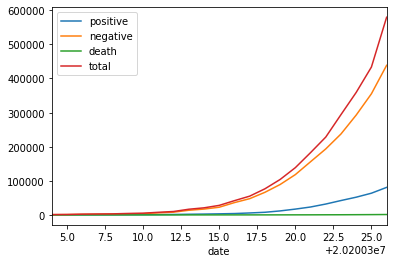

In [12]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [13]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
20200312,987,29
20200313,1264,36
20200314,1678,41
20200315,1678,41
20200316,1678,41
20200317,3503,58
20200318,3536,58
20200319,7087,100
20200320,10442,150


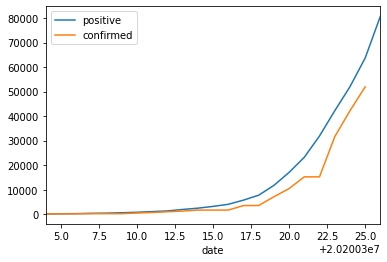

In [14]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [15]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,
20200320,1063,10424,0,0.0,20,11487,11487,2.0,0.0,1637.0,139.0,1776.0
20200321,1279,11249,0,0.0,24,12528,12528,4.0,0.0,825.0,216.0,1041.0
20200322,1536,11304,0,0.0,27,12840,12840,3.0,0.0,55.0,257.0,312.0
20200323,1733,12567,12100,0.0,27,26400,14300,0.0,0.0,1263.0,197.0,1460.0
20200324,2102,13452,12100,0.0,40,27654,15554,13.0,0.0,885.0,369.0,1254.0
20200325,2102,13452,12100,0.0,40,27654,15554,0.0,0.0,0.0,0.0,0.0
20200326,3006,17380,57400,0.0,65,77786,20386,25.0,0.0,3928.0,904.0,4832.0


In [16]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    83836
dead          1209
dtype: int64

In [17]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    3899
dead           81
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [19]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                83836
China             81782
Italy             80589
Spain             57786
Germany           43938
France            29551
Iran              29406
United Kingdom    11812
Switzerland       11811
Korea, South       9241
Name: confirmed, dtype: int64

In [20]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(20)

country
US                83836
China             81782
Italy             80589
Spain             57786
Germany           43938
France            29551
Iran              29406
United Kingdom    11812
Switzerland       11811
Korea, South       9241
Netherlands        7468
Austria            6909
Belgium            6235
Canada             4042
Turkey             3629
Portugal           3544
Norway             3369
Brazil             2985
Sweden             2840
Australia          2810
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [25]:
dfState.loc['NY'].head(7)

,date,positive,current_total,pct
state,,,,
NY,20200326,37258,37258,1.000000
NY,20200325,30811,37258,0.826963
NY,20200324,25665,37258,0.688845
NY,20200323,20875,37258,0.560282
NY,20200322,15168,37258,0.407107
NY,20200321,10356,37258,0.277954
NY,20200320,7102,37258,0.190617


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

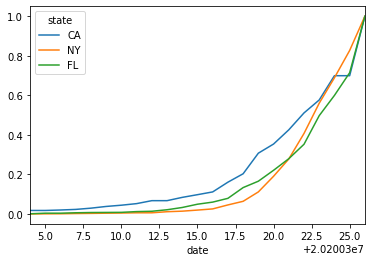

In [27]:
x = res.loc[:, ['CA','NY','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

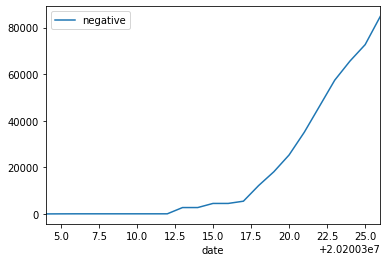

In [29]:
x = dfNYTesting.plot.line()

In [30]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['GA']))].head(10)

,state,date,positive,current_total,pct
227,GA,20200326,1525,1525,1.000000
228,GA,20200325,1247,1525,0.817705
229,GA,20200324,1026,1525,0.672787
230,GA,20200323,772,1525,0.506230
231,GA,20200322,600,1525,0.393443
232,GA,20200321,507,1525,0.332459
233,GA,20200320,420,1525,0.275410
234,GA,20200319,287,1525,0.188197
235,GA,20200318,197,1525,0.129180
236,GA,20200317,146,1525,0.095738


In [31]:
datecutoff = int(((pd.to_datetime(str(dfDates.date.max())))-datetime.timedelta(days=2)).strftime("%Y%m%d"))
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .60)].sort_values(by='positive',ascending=False)


,state,date,positive,current_total,pct
697,NJ,20200324,3675,6876,0.534468
206,FL,20200324,1412,2355,0.599575
430,MA,20200324,1159,2417,0.479520
850,PA,20200324,851,1687,0.504446
967,TX,20200324,410,1396,0.293696
347,IN,20200324,365,645,0.565891
23,AL,20200324,215,506,0.424901
538,MO,20200324,183,502,0.364542
163,DC,20200324,137,231,0.593074
807,OK,20200324,106,248,0.427419
